# Phase Circuit to CNOT+Rz+Rx gates
We have shown in the previous notebooks how to simplify and optimize Phase Circuits.
However, the multi-qubit phase gadgets in those examples are not suitable for direct execution on most quantum devices. Therefore, they are decomposed into CNOTs and single qubit gates that are allowed by the hardware.
In the previous notebooks, we have used a naive decomposing strategy for the phase gadgets. 

However, more intrigate strategies for decomposing sequences of phase gadgets are available. These have been implemented and we will see how they perform compared to the naive strategy.

## Some administrative setup

Changing working directory from `./notebooks/` to `./`, in order to import the Python packages defined in the repository

In [1]:
import os
DEBUG = True
try:
    print("Original working directory: %s"%str(original_wd)) # type: ignore
    """
        You only get here if you---by mistake or otherwise---are re-running this cell, 
        in which case the working should not be changed again.
    """
except NameError:
    original_wd = os.getcwd()
    os.chdir('../')
print("Current working directory: %s"%str(os.getcwd()))

Current working directory: /Users/griendar/Documents/Github/pauliopt


General purpose imports:

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import numpy as np
# import qiskit

/var/folders/3q/vjbn2sl16r1g41lg5pk752khfzf5fm/T/ipykernel_56981/3958425799.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


Some utility code to display HTML elements and images/figures side-by-side:

In [3]:
from io import BytesIO
from typing import Union
from IPython.display import Image, HTML # type: ignore
def figure_to_image(fig: plt.Figure, fmt: str = "png") -> Image:
    """ Converts a Matplotlib figure to a PNG IPython Image. """
    buffer = BytesIO()
    fig.savefig(buffer, format=fmt)
    buffer.seek(0)
    image_png = buffer.getvalue()
    buffer.close()
    return Image(image_png, format=fmt, embed=True)
def side_by_side(*elements: Union[str, Image]) -> HTML:
    """
        Returns an HTML Div element with the given elements
        displayed side by side. Accepts raw HTML code or
        IPython Image objects.
    """
    html = f"<div style='display:flex; align-items: center;'>"
    for el in elements:
        if isinstance(el, str):
            html += el
        elif isinstance(el, Image):
            html += f"<img src='data:image/png;base64,{el._repr_png_()}'/>"
    html += f"</div>"
    return HTML(html)

## PhaseCircuit decomposition to CNOTs

For our running example, we use a 3x3 grid qubit topology:

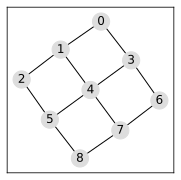

In [4]:
from pauliopt.topologies import Topology
topology = Topology.grid(3, 3)
topology.draw(figsize=(3, 3))

We construct a small random phase circuit on the same qubits:

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


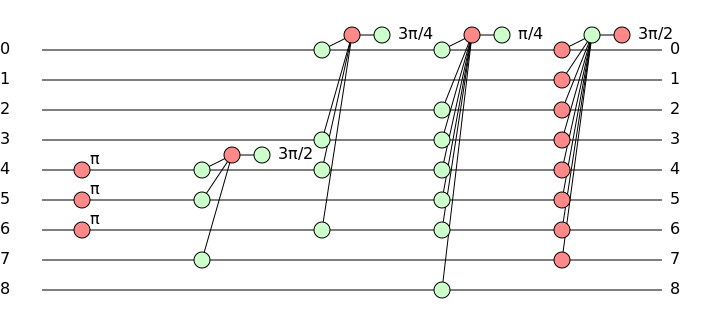

In [5]:
from pauliopt.phase import PhaseCircuit, CXCircuit
import pyzx
orig_circuit = PhaseCircuit.random(topology.num_qubits, 5, min_legs=3, rng_seed=0).simplified()
orig_circuit

In [6]:
def draw_qiskit_circuit(phasecircuit, topology, method):
    circuit = phasecircuit.to_qiskit(topology, method)
    print(circuit.count_ops())
    display(circuit.draw())
    return circuit

def circuit_to_pyzx(circuit):
    diagram = pyzx.Circuit.from_qasm(circuit.qasm())
    display(pyzx.draw(diagram))
    return diagram


We then decompose the circuit into CNOTs and single qubit rotations

Count the number of operators for each of the circuits

In [7]:
orig_circuit_naive = draw_qiskit_circuit(orig_circuit, topology, "naive")
orig_circuit_diagram = circuit_to_pyzx(orig_circuit_naive)

OrderedDict([('cx', 36), ('rx', 4), ('rz', 3)])


┌───┐┌──────────┐»
q_0: ────────────────────────────────────────────────────────┤ X ├┤ Rz(3π/4) ├»
                                                             └─┬─┘└──────────┘»
q_1: ──────────────────────────────────────────────────────────┼──────────────»
                                                               │              »
q_2: ───────────────────────────────────────────■──────────────┼──────────────»
                                                │  ┌───┐┌───┐  │              »
q_3: ───────────────────────────────────────────┼──┤ X ├┤ X ├──■──────────────»
     ┌───────┐┌───┐┌───┐┌──────────┐┌───┐┌───┐  │  └─┬─┘└─┬─┘                 »
q_4: ┤ Rx(π) ├┤ X ├┤ X ├┤ Rz(3π/2) ├┤ X ├┤ X ├──┼────■────┼───────────────────»
     ├───────┤└─┬─┘└─┬─┘└──────────┘└─┬─┘└─┬─┘┌─┴─┐┌───┐  │                   »
q_5: ┤ Rx(π) ├──┼────■────────────────■────┼──┤ X ├┤ X ├──┼───────────────────»
     ├───────┤  │                          │  └───┘└─┬─┘  │                   »
q_6: ┤ Rx(π) ├──┼──────────────────────────┼─────────┼────■───────────────────»
     └───────┘  │                          │         │                        »
q_7: ───────────■──────────────────────────■─────────┼────────────────────────»
                                                     │                        »
q_8: ────────────────────────────────────────────────■────────────────────────»
                                                                              »
«     ┌───┐                         ┌───┐┌─────────┐┌───┐                    »
«q_0: ┤ X ├─────────────────────────┤ X ├┤ Rz(π/4) ├┤ X ├────────────────────»
«     └─┬─┘                         └─┬─┘└─────────┘└─┬─┘                    »
«q_1: ──┼─────────────────────────────┼───────────────┼──────────────────────»
«       │                             │               │                      »
«q_2: ──┼─────────────────────────────┼───────────────┼──────────────────────»
«       │  ┌───┐┌───┐     ┌───┐┌───┐  │               │  ┌───┐┌───┐          »
«q_3: ──■──┤ X ├┤ X ├─────┤ X ├┤ X ├──■───────────────■──┤ X ├┤ X ├───────■──»
«          └─┬─┘└─┬─┘┌───┐└─┬─┘└─┬─┘                     └─┬─┘└─┬─┘┌───┐  │  »
«q_4: ───────┼────■──┤ X ├──■────┼─────────────────────────┼────■──┤ X ├──┼──»
«            │       └─┬─┘       │                         │       └─┬─┘  │  »
«q_5: ───────┼─────────■─────────┼─────────────────────────┼─────────■────┼──»
«            │                   │                         │            ┌─┴─┐»
«q_6: ───────■───────────────────■─────────────────────────■────────────┤ X ├»
«                                                                       └───┘»
«q_7: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_8: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«                                        ┌──────────┐                         »
«q_0: ──■─────────────────────────────■──┤ Rx(3π/2) ├──■────■─────────────────»
«       │                           ┌─┴─┐└──────────┘┌─┴─┐  │                 »
«q_1: ──┼──────────────■─────────■──┤ X ├────────────┤ X ├──┼────■────■───────»
«       │              │       ┌─┴─┐└───┘            └───┘  │  ┌─┴─┐  │       »
«q_2: ──┼─────────■────┼────■──┤ X ├────────────────────────┼──┤ X ├──┼────■──»
«     ┌─┴─┐       │    │    │  └───┘                      ┌─┴─┐└───┘  │    │  »
«q_3: ┤ X ├───────┼────┼────┼─────────────────────────────┤ X ├──■────┼────┼──»
«     └───┘       │  ┌─┴─┐  │                             └───┘  │  ┌─┴─┐  │  »
«q_4: ───────■────┼──┤ X ├──┼────────────────────────────────────┼──┤ X ├──┼──»
«     ┌───┐  │  ┌─┴─┐└───┘┌─┴─┐                                  │  └───┘┌─┴─┐»
«q_5: ┤ X ├──┼──┤ X ├─────┤ X ├──────────────────────────────────┼───────┤ X ├»
«     └─┬─┘  │  └───┘     └───┘                                ┌─┴─┐     └───┘»


None

In [8]:
def check_equivalence(diagram):
    return orig_circuit_diagram.verify_equality(diagram)

def check_equivalence_circuit(circuit):
    return check_equivalence(circuit_to_pyzx(circuit))

orig_circuit_parity = draw_qiskit_circuit(orig_circuit, topology, "paritysynth")
check_equivalence_circuit(orig_circuit_parity)

OrderedDict([('cx', 34), ('rx', 4), ('rz', 3)])


┌───┐┌──────────┐»
q_0: ────────────────────────────────────────────────────────┤ X ├┤ Rz(3π/4) ├»
                                                             └─┬─┘└──────────┘»
q_1: ──────────────────────────────────────────────────────────┼──────────────»
                                                        ┌───┐  │              »
q_2: ───────────────────────────────────────────────────┤ X ├──┼──────────────»
                                              ┌───┐┌───┐└─┬─┘  │              »
q_3: ─────────────────────────────────────────┤ X ├┤ X ├──┼────■───────■──────»
     ┌───────┐┌───┐┌───┐┌──────────┐┌───┐┌───┐└─┬─┘└─┬─┘  │            │      »
q_4: ┤ Rx(π) ├┤ X ├┤ X ├┤ Rz(3π/2) ├┤ X ├┤ X ├──■────┼────┼────────────┼──────»
     ├───────┤└─┬─┘└─┬─┘└──────────┘└─┬─┘└─┬─┘┌───┐  │    │            │      »
q_5: ┤ Rx(π) ├──┼────■────────────────┼────■──┤ X ├──┼────■────────────┼──────»
     ├───────┤  │                     │       └─┬─┘  │               ┌─┴─┐    »
q_6: ┤ Rx(π) ├──┼─────────────────────┼─────────┼────■───────────────┤ X ├────»
     └───────┘  │                     │         │                    └───┘    »
q_7: ───────────■─────────────────────■─────────┼─────────────────────────────»
                                                │                             »
q_8: ───────────────────────────────────────────■─────────────────────────────»
                                                                              »
«     ┌───┐┌─────────┐┌───┐                                ┌───┐               »
«q_0: ┤ X ├┤ Rz(π/4) ├┤ X ├────────────────────────────────┤ X ├───────────────»
«     └─┬─┘└─────────┘└─┬─┘     ┌──────────┐     ┌───┐┌───┐└─┬─┘┌───┐┌───┐     »
«q_1: ──┼───────────────┼────■──┤ Rx(3π/2) ├─────┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──»
«       │               │    │  └──────────┘     └─┬─┘└─┬─┘     └─┬─┘└─┬─┘  │  »
«q_2: ──■───────────────┼────┼─────────────────────┼────■─────────┼────■────┼──»
«     ┌───┐             │    │              ┌───┐  │              │         │  »
«q_3: ┤ X ├─────────────■────┼───────■──────┤ X ├──┼──────────────┼─────────┼──»
«     └─┬─┘                ┌─┴─┐     │      └─┬─┘  │              │       ┌─┴─┐»
«q_4: ──■───────■───────■──┤ X ├─────┼────────┼────■──────────────■───────┤ X ├»
«               │     ┌─┴─┐└───┘     │        │                           └───┘»
«q_5: ──────────┼─────┤ X ├──────────┼────────┼────────────────────────────────»
«               │     └───┘        ┌─┴─┐      │                                »
«q_6: ──────────┼──────────────────┤ X ├──────■────────────────────────────────»
«             ┌─┴─┐                └───┘                                       »
«q_7: ────────┤ X ├────────────────────────────────────────────────────────────»
«             └───┘                                                            »
«q_8: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«                                                       
«q_0: ──────────────────────────────────────────────────
«                                                       
«q_1: ──────────────────────────────────────────────────
«               ┌───┐                                   
«q_2: ──────────┤ X ├───────────────────────────────────
«     ┌───┐     └─┬─┘                                   
«q_3: ┤ X ├───────┼─────────────────────────────────────
«     └─┬─┘       │  ┌───┐                    ┌───┐     
«q_4: ──■────■────┼──┤ X ├───────■─────────■──┤ X ├──■──
«          ┌─┴─┐  │  └─┬─┘┌───┐  │         │  └─┬─┘  │  
«q_5: ─────┤ X ├──■────┼──┤ X ├──┼─────────┼────┼────┼──
«          └───┘       │  └─┬─┘  │  ┌───┐  │    │    │  
«q_6: ─────────────────┼────┼────┼──┤ X ├──┼────┼────┼──
«                      │    │  ┌─┴─┐└─┬─┘┌─┴─┐  │  ┌─┴─┐
«q_7: ─────────────────■────┼──┤ X ├──■──┤ X ├──■──┤ X ├
«                           │  └───┘     └───┘     └───┘
«q_8: ──────────────────────■────

None

True

# Using this decomposition method together with the annealing optimization

In [9]:
from pauliopt.phase import OptimizedPhaseCircuit
from math import log10, ceil
def log_iter(it, prev_cost, new_cost, accepted, flip, t, num_iters):
    if new_cost < prev_cost:
        print(f"Iter #{it:>0{ceil(log10(num_iters-1))}}, new cost: {new_cost}")
loggers = {
    "log_start": lambda cost, num_iters: print(f"Init cost: {cost}"),
    "log_iter": log_iter,
    "log_end": lambda cost, num_iters: print(f"Final cost: {cost}"),
}

In [10]:
def opt_to_qiskit(opt, method):
    qiskit_circuit = opt.to_qiskit(method)
    display(qiskit_circuit.draw())
    print(qiskit_circuit.count_ops())
    print("cx" in qiskit_circuit.count_ops())
    print(check_equivalence_circuit(qiskit_circuit))
    
def run_annealer(circuit, cx_block, method):
    opt = OptimizedPhaseCircuit(orig_circuit, topology, cx_block=cx_block, rng_seed=0, method=method)
    opt.anneal(1000, schedule=("geometric", 1, 1e-5), loggers=loggers, method=method)

    display(opt.phase_block.to_svg(scale=0.8))
    display(opt.cx_block.draw(figsize=(3, 3)))
    opt_to_qiskit(opt, method)
    return opt

Init cost: 36
Iter #003, new cost: 38
Iter #006, new cost: 36
Iter #023, new cost: 44
Iter #100, new cost: 44
Iter #139, new cost: 40
Iter #240, new cost: 38
Iter #241, new cost: 32
Iter #576, new cost: 30
Final cost: 30


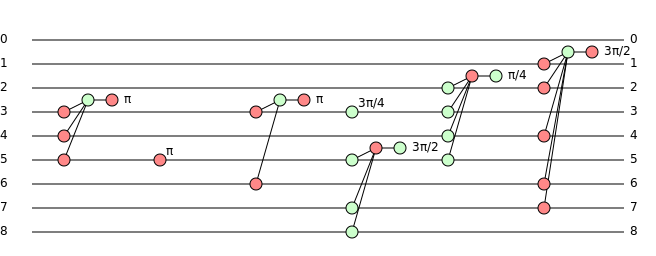

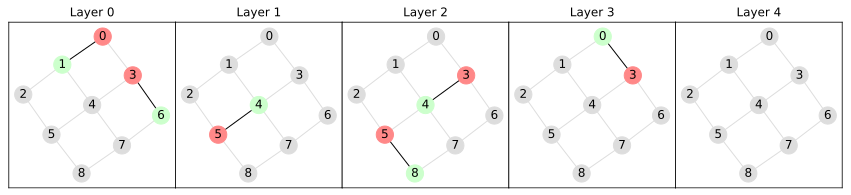

None

┌───┐                                                          »
q_0: ──■──┤ X ├──────────────────────────────────────────────────────────»
       │  └─┬─┘                                                          »
q_1: ──┼────■────────────────────────────────────────────────────────────»
       │                                                                 »
q_2: ──┼─────────────────────────────────────────────────────────────────»
     ┌─┴─┐┌───┐     ┌───┐          ┌───────┐               ┌───────┐     »
q_3: ┤ X ├┤ X ├─────┤ X ├───────■──┤ Rx(π) ├──■─────────■──┤ Rx(π) ├──■──»
     └───┘└─┬─┘     └─┬─┘     ┌─┴─┐└───────┘┌─┴─┐       │  └───────┘  │  »
q_4: ───────■────■────┼────■──┤ X ├─────────┤ X ├──■────┼─────────────┼──»
     ┌───┐     ┌─┴─┐  │  ┌─┴─┐└───┘         └───┘┌─┴─┐  │  ┌───────┐  │  »
q_5: ┤ X ├─────┤ X ├──┼──┤ X ├───────────────────┤ X ├──┼──┤ Rx(π) ├──┼──»
     └─┬─┘     └───┘  │  └───┘                   └───┘┌─┴─┐└───────┘┌─┴─┐»
q_6: ──┼──────────────■───────────────────────────────┤ X ├─────────┤ X ├»
       │                                              └───┘         └───┘»
q_7: ──┼────■────────────────────────────────────────────────────────────»
       │  ┌─┴─┐                                                          »
q_8: ──■──┤ X ├──────────────────────────────────────────────────────────»
          └───┘                                                          »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                       ┌───┐┌─────────┐┌───┐               »
«q_2: ──────────────────────────────────┤ X ├┤ Rz(π/4) ├┤ X ├───────────────»
«     ┌──────────┐                      └─┬─┘└─────────┘└─┬─┘               »
«q_3: ┤ Rz(3π/4) ├─────■──────────────────┼───────────────┼─────────■───────»
«     └──────────┘   ┌─┴─┐                │               │       ┌─┴─┐     »
«q_4: ───────────────┤ X ├───────────■────┼───────────────┼────■──┤ X ├──■──»
«        ┌───┐    ┌──┴───┴───┐┌───┐┌─┴─┐  │               │  ┌─┴─┐└───┘  │  »
«q_5: ───┤ X ├────┤ Rz(3π/2) ├┤ X ├┤ X ├──■───────────────■──┤ X ├───────┼──»
«        └─┬─┘    └──────────┘└─┬─┘└───┘┌───┐                └───┘       │  »
«q_6: ─────┼────────────────────┼───────┤ X ├────────────────────────────┼──»
«          │                    │       └─┬─┘                          ┌─┴─┐»
«q_7: ─────┼────────────────────┼────■────■────────────────────────────┤ X ├»
«          │                    │  ┌─┴─┐                               └───┘»
«q_8: ─────■────────────────────■──┤ X ├────────────────────────────────────»
«                                  └───┘                                    »
«                                     ┌───┐                    
«q_0: ────────────────────────────────┤ X ├─────────────────■──
«               ┌──────────┐          └─┬─┘                 │  
«q_1: ──■────■──┤ Rx(3π/2) ├──■────■────■───────────────────┼──
«       │  ┌─┴─┐└──────────┘┌─┴─┐  │                        │  
«q_2: ──┼──┤ X ├────────────┤ X ├──┼────────────────────────┼──
«       │  └───┘            └───┘  │            ┌───┐┌───┐┌─┴─┐
«q_3: ──┼──────────────────────────┼────────────┤ X ├┤ X ├┤ X ├
«     ┌─┴─┐                      ┌─┴─┐          └─┬─┘└─┬─┘└───┘
«q_4: ┤ X ├──────────────────────┤ X ├──■────■────┼────■───────
«     └───┘                      └───┘  │  ┌─┴─┐  │  ┌───┐     
«q_5: ──────────────────────────────────┼──┤ X ├──┼──┤ X ├─────
«                                       │  ├───┤  │  └─┬─┘     
«q_6: ──────────────────────────────────┼──┤ X ├──■────┼───────
«                                     ┌─┴─┐└─┬─┘       │       
«q_7: ────────────────────────────────┤ X ├──■─────────┼───────
«                                     └───┘            │       
«q_8: ─────────

OrderedDict([('cx', 36), ('rx', 4), ('rz', 3)])
True


None

True


In [11]:
opt_naive = run_annealer(orig_circuit, 5, "naive")

Init cost: 34
Iter #002, new cost: 30
Iter #009, new cost: 32
Iter #141, new cost: 32
Iter #165, new cost: 31
Iter #169, new cost: 30
Iter #972, new cost: 28
Final cost: 28


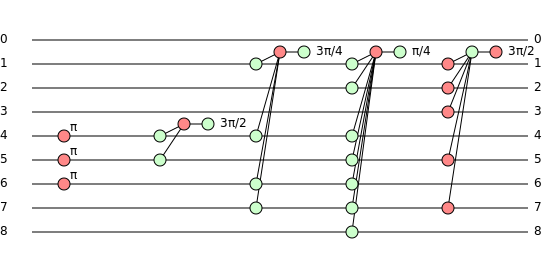

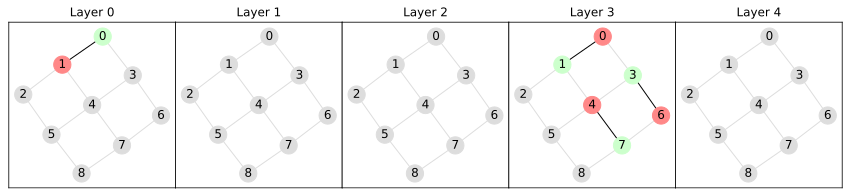

None

┌───┐                                                               »
q_0: ┤ X ├──■────────────────────────────────────────────────────────────»
     └─┬─┘┌─┴─┐                                    ┌───┐┌──────────┐┌───┐»
q_1: ──■──┤ X ├────────────────────────────────────┤ X ├┤ Rz(3π/4) ├┤ X ├»
          └───┘                                    └─┬─┘└──┬───┬───┘└─┬─┘»
q_2: ────────────────────────────────────────────────┼─────┤ X ├──────■──»
                                                     │     └─┬─┘         »
q_3: ───────■────────────────────────────────────────┼───────┼───────────»
     ┌───┐  │  ┌───────┐┌───┐┌──────────┐┌───┐┌───┐  │       │           »
q_4: ┤ X ├──┼──┤ Rx(π) ├┤ X ├┤ Rz(3π/2) ├┤ X ├┤ X ├──■───────┼────────■──»
     └─┬─┘  │  ├───────┤└─┬─┘└──────────┘└─┬─┘└─┬─┘┌───┐     │        │  »
q_5: ──┼────┼──┤ Rx(π) ├──■────────────────┼────■──┤ X ├─────■────────┼──»
       │  ┌─┴─┐├───────┤                   │       └─┬─┘              │  »
q_6: ──┼──┤ X ├┤ Rx(π) ├──■────────────────┼─────────┼────────────────┼──»
       │  └───┘└───────┘┌─┴─┐              │         │              ┌─┴─┐»
q_7: ──■────────────────┤ X ├──────────────■─────────┼──────────────┤ X ├»
                        └───┘                        │              └───┘»
q_8: ────────────────────────────────────────────────■───────────────────»
                                                                         »
«                                                     ┌───┐                    »
«q_0: ─────────────────────────────────────────────■──┤ X ├────────────────────»
«     ┌─────────┐                      ┌───┐┌───┐┌─┴─┐└─┬─┘                    »
«q_1: ┤ Rz(π/4) ├──────────────────────┤ X ├┤ X ├┤ X ├──■──────────────────────»
«     └─────────┘                      └─┬─┘└─┬─┘├───┤                         »
«q_2: ───────────────────────────────────┼────■──┤ X ├─────────────────────────»
«                     ┌──────────┐       │       └─┬─┘                         »
«q_3: ─────────────■──┤ Rx(3π/2) ├──■────┼─────────┼───────────────────────────»
«                ┌─┴─┐└──────────┘┌─┴─┐  │         │       ┌───┐          ┌───┐»
«q_4: ─────■─────┤ X ├────────────┤ X ├──■────■────┼────■──┤ X ├──────────┤ X ├»
«        ┌─┴─┐   └───┘            └───┘     ┌─┴─┐  │    │  └─┬─┘┌───┐     └─┬─┘»
«q_5: ───┤ X ├──────────────────────────────┤ X ├──■────┼────┼──┤ X ├───────┼──»
«        └───┘                              └───┘       │    │  └─┬─┘       │  »
«q_6: ──────────────────────────────────────────────────┼────┼────┼────■────┼──»
«                                                     ┌─┴─┐  │    │  ┌─┴─┐  │  »
«q_7: ────────────────────────────────────────────────┤ X ├──■────┼──┤ X ├──■──»
«                                                     └───┘       │  └───┘     »
«q_8: ────────────────────────────────────────────────────────────■────────────»
«                                                                              »
«          
«q_0: ─────
«          
«q_1: ─────
«          
«q_2: ─────
«          
«q_3: ──■──
«       │  
«q_4: ──┼──
«       │  
«q_5: ──┼──
«     ┌─┴─┐
«q_6: ┤ X ├
«     └───┘
«q_7: ─────
«          
«q_8: ─────
«

OrderedDict([('cx', 28), ('rx', 4), ('rz', 3)])
True


None

True


In [12]:
opt_parity = run_annealer(orig_circuit, 5, "paritysynth")

In [13]:
opt_to_qiskit(opt_naive, "paritysynth")

┌───┐                                                                »
q_0: ──■──┤ X ├────────────────────────────────────────────────────────────────»
       │  └─┬─┘                                                                »
q_1: ──┼────■──────────────────────────────────────────────────────────────────»
       │                                                                       »
q_2: ──┼───────────────────────────────────────────────────────────────────────»
     ┌─┴─┐┌───┐     ┌───┐              ┌───────┐          ┌───────┐┌──────────┐»
q_3: ┤ X ├┤ X ├─────┤ X ├───────────■──┤ Rx(π) ├──■────■──┤ Rx(π) ├┤ Rz(3π/4) ├»
     └───┘└─┬─┘     └─┬─┘           │  └───────┘  │  ┌─┴─┐└─┬───┬─┘└──┬───┬───┘»
q_4: ───────■────■────┼─────────────┼──────■──────┼──┤ X ├──┤ X ├─────┤ X ├────»
     ┌───┐     ┌─┴─┐  │  ┌───────┐  │    ┌─┴─┐    │  ├───┤  └─┬─┘     └─┬─┘    »
q_5: ┤ X ├─────┤ X ├──┼──┤ Rx(π) ├──┼────┤ X ├────┼──┤ X ├────┼─────────■──────»
     └─┬─┘     └───┘  │  └───────┘┌─┴─┐  └───┘  ┌─┴─┐└─┬─┘    │                »
q_6: ──┼──────────────■───────────┤ X ├─────────┤ X ├──┼──────┼─────────■──────»
       │                          └───┘         └───┘  │      │       ┌─┴─┐    »
q_7: ──┼───────────────────────────────────────────────┼──────■───────┤ X ├────»
       │                                               │              └───┘    »
q_8: ──■───────────────────────────────────────────────■───────────────────────»
                                                                               »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                               ┌──────────┐»
«q_1: ──────────────────────────────────────────────────■────■──┤ Rx(3π/2) ├»
«                                     ┌───┐┌─────────┐  │    │  └──────────┘»
«q_2: ────────────────────────────────┤ X ├┤ Rz(π/4) ├──┼────┼──────────────»
«     ┌───┐┌──────────┐               └─┬─┘└─────────┘  │  ┌─┴─┐            »
«q_3: ┤ X ├┤ Rz(3π/2) ├──■─────────■────┼───────────────┼──┤ X ├────────────»
«     └─┬─┘└──────────┘┌─┴─┐       │    │               │  └───┘            »
«q_4: ──■──────────────┤ X ├──■────┼────┼───────────────┼───────────────────»
«     ┌───┐            └───┘┌─┴─┐  │    │             ┌─┴─┐                 »
«q_5: ┤ X ├─────────────────┤ X ├──┼────■─────────────┤ X ├─────────────────»
«     └─┬─┘                 └───┘┌─┴─┐                └───┘                 »
«q_6: ──┼────────────────────────┤ X ├──■───────────────────────────────────»
«       │                        └───┘┌─┴─┐                                 »
«q_7: ──┼─────────────────────────────┤ X ├─────────────────────────────────»
«       │                             └───┘                                 »
«q_8: ──■───────────────────────────────────────────────────────────────────»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──■───────────────────────────────────────────────────────────────────»
«     ┌─┴─┐┌───┐                                                            »
«q_2: ┤ X ├┤ X ├────────────────────────────────────────────────────────────»
«     └───┘└─┬─┘                         ┌───┐          ┌───┐               »
«q_3: ───────┼────────────────────────■──┤ X ├───────■──┤ X ├──■────────────»
«            │                 ┌───┐  │  └─┬─┘┌───┐┌─┴─┐└─┬─┘┌─┴─┐          »
«q_4: ───────┼─────────────────┤ X ├──┼────■──┤ X ├┤ X ├──■──┤ X ├──■───────»
«            │            ┌───┐└─┬─┘  │       └─┬─┘└───┘     └───┘  │       »
«q_5: ───────■────■───────┤ X ├──■────┼─────────■───────────────────┼───────»
«                 │       └─┬─┘     ┌─┴─┐            

OrderedDict([('cx', 77), ('rx', 4), ('rz', 3)])
True


None

True


In [14]:
opt_to_qiskit(opt_parity, "naive")

┌───┐                                                                    »
q_0: ┤ X ├──■─────────────────────────────────────────────────────────────────»
     └─┬─┘┌─┴─┐                                    ┌───┐┌──────────┐┌───┐     »
q_1: ──■──┤ X ├────────────────────────────────────┤ X ├┤ Rz(3π/4) ├┤ X ├─────»
          └───┘                                    └─┬─┘└──┬───┬───┘└─┬─┘     »
q_2: ────────────────────────────────────────────────┼─────┤ X ├──────┼───────»
                                                     │     └─┬─┘      │       »
q_3: ───────■────────────────────────────────────────┼───────┼────────┼───────»
     ┌───┐  │  ┌───────┐┌───┐┌──────────┐┌───┐┌───┐  │       │        │  ┌───┐»
q_4: ┤ X ├──┼──┤ Rx(π) ├┤ X ├┤ Rz(3π/2) ├┤ X ├┤ X ├──■───────┼────────■──┤ X ├»
     └─┬─┘  │  ├───────┤└─┬─┘└──────────┘└─┬─┘└─┬─┘┌───┐     │           └─┬─┘»
q_5: ──┼────┼──┤ Rx(π) ├──■────────────────■────┼──┤ X ├─────■─────────────┼──»
       │  ┌─┴─┐├───────┤                        │  └─┬─┘                   │  »
q_6: ──┼──┤ X ├┤ Rx(π) ├──■─────────────────────┼────┼─────────────────────┼──»
       │  └───┘└───────┘┌─┴─┐                   │    │                     │  »
q_7: ──■────────────────┤ X ├───────────────────■────┼─────────────────────■──»
                        └───┘                        │                        »
q_8: ────────────────────────────────────────────────■────────────────────────»
                                                                              »
«                                                                            »
«q_0: ───────────────────────────────────────────────────────────────────────»
«                    ┌───┐┌───┐┌─────────┐┌───┐┌───┐                         »
«q_1: ───────────────┤ X ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ X ├───────■──────────────■──»
«                    └─┬─┘└─┬─┘└─────────┘└─┬─┘└─┬─┘┌───┐  │            ┌─┴─┐»
«q_2: ─────────────────┼────■───────────────■────┼──┤ X ├──┼─────────■──┤ X ├»
«                      │                         │  └─┬─┘┌─┴─┐       │  └───┘»
«q_3: ─────────────────┼─────────────────────────┼────┼──┤ X ├───────┼───────»
«               ┌───┐  │                         │    │  ├───┤       │       »
«q_4: ──────────┤ X ├──■─────────────────────────■────┼──┤ X ├───────┼───────»
«               └─┬─┘                                 │  └─┬─┘┌───┐┌─┴─┐     »
«q_5: ────────────┼───────────────────────────────────■────┼──┤ X ├┤ X ├─────»
«                 │                                        │  └─┬─┘└───┘     »
«q_6: ──■────■────┼────────────────────────────────────────┼────┼────■───────»
«     ┌─┴─┐┌─┴─┐  │                                        │    │  ┌─┴─┐     »
«q_7: ┤ X ├┤ X ├──■────────────────────────────────────────■────┼──┤ X ├─────»
«     └───┘└───┘                                                │  └───┘     »
«q_8: ──────────────────────────────────────────────────────────■────────────»
«                                                                            »
«                                          ┌───┐
«q_0: ──────────────────────────────────■──┤ X ├
«          ┌──────────┐               ┌─┴─┐└─┬─┘
«q_1: ──■──┤ Rx(3π/2) ├──■────■────■──┤ X ├──■──
«       │  └──────────┘  │  ┌─┴─┐  │  └───┘     
«q_2: ──┼────────────────┼──┤ X ├──┼────■───────
«       │                │  └───┘┌─┴─┐  │       
«q_3: ──┼────────────────┼───────┤ X ├──┼────■──
«       │                │  ┌───┐└───┘  │    │  
«q_4: ──┼────────────────┼──┤ X ├───────┼────┼──
«       │                │  └─┬─┘     ┌─┴─┐  │  
«q_5: ──┼────────────────┼────┼───────┤ X ├──┼──
«       │                │    │       └───┘┌─┴─┐
«q_6: ──┼────────────────┼────┼────────────┤ X ├
«     ┌─┴─┐            ┌─┴─┐  │            └───┘
«q_7: ┤ X ├────────────┤ X ├──■─────────────────
«     └───┘            └───┘                    
«q_8: ──────────────────────────────────────────
«

OrderedDict([('cx', 36), ('rx', 4), ('rz', 3)])
True


None

True


# Experiments
We now generate many random phase circuits and compile them in different ways to the same architecture and count their respective CNOT costs.

In [15]:
import pandas as pd
import time

In [16]:
from qiskit import transpile

def compile_with_qiskit(circuit, topology):
     return transpile(circuit, 
                      optimization_level=3, 
                      basis_gates=['u1', 'u2', 'u3', 'cx'], 
                      coupling_map=[[v for v in c] for c in topology._couplings])
    

In [17]:
from pytket.architecture import Architecture
from pytket.transform import Transform
from pytket.passes import SequencePass, DecomposeBoxes, FullPeepholeOptimise, CXMappingPass, NaivePlacementPass, KAKDecomposition, CliffordSimp, SynthesiseTK, RebaseTket, RemoveRedundancies, SimplifyInitial
from pytket.predicates import CompilationUnit
from pytket.placement import Placement
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit

def compile_with_tket(circuit, topology):
    architecture = Architecture([[v for v in c] for c in topology._couplings])
    placer = Placement(architecture)
    compilation_pass = SequencePass([DecomposeBoxes(), FullPeepholeOptimise(), CXMappingPass(architecture, placer), 
                                    NaivePlacementPass(architecture), KAKDecomposition(), CliffordSimp(allow_swaps=False),
                                    SynthesiseTK(), RebaseTket(), RemoveRedundancies(), SimplifyInitial(allow_classical=False, create_all_qubits=True)])
    tkcirc = qiskit_to_tk(circuit)
    cu = CompilationUnit(tkcirc)
    compilation_pass.apply(cu)
    
    return tk_to_qiskit(cu.circuit)

In [18]:
def count_cnots(circuit):
    ops = circuit.count_ops()
    if "cx" in ops:
        return ops["cx"]
    return 0

def compile_time_and_count(compiler_function, *args):
    start_time = time.process_time()
    compiled_circuit = compiler_function(*args)
    elapsed_time = time.process_time() - start_time
    return count_cnots(compiled_circuit), elapsed_time

def compile_anneal(circuit, topology, cx_block, method, n_iter):
    opt =  OptimizedPhaseCircuit(circuit, topology, cx_block=cx_block, method=method)
    opt.anneal(n_iter, schedule=("geometric", 1, 1e-5), method=method)
    return opt.to_qiskit(method)

def generate_and_compile(n_gadgets, topology, cx_block=5, n_iter=100):
    data = {}
    circuit = PhaseCircuit.random(topology.num_qubits, n_gadgets, min_legs=int(np.round(np.sqrt(topology.num_qubits)))).simplified()
    qiskit_circuit = circuit.to_qiskit(topology, "naive")
    data["original"] = count_cnots(qiskit_circuit)
    data["qiskit"], data["qiskit time"] = compile_time_and_count(compile_with_qiskit, qiskit_circuit, topology)
    data["tket"], data["tket time"] = compile_time_and_count(compile_with_tket, qiskit_circuit, topology)
    data["parity"], data["parity time"] = compile_time_and_count(circuit.to_qiskit, topology, "paritysynth")
    data["annealer"], data["annealer time"] = compile_time_and_count(compile_anneal, circuit, topology, cx_block, "naive", n_iter)
    data["annealer+parity"], data["annealer+parity time"] = compile_time_and_count(compile_anneal, circuit, topology, cx_block, "paritysynth", n_iter)
    return data

In [19]:
from qiskit.providers.fake_provider import FakeSingapore, FakeJohannesburg, FakeYorktown, FakeMelbourne, FakeValencia

In [ ]:
n = 100
print("Results for", n, "randomly generated phase circuits")
gadgets = [1,2,5,10,50,100]#,1000]
results = []
devices = {
    "Singapore": Topology.from_qiskit_backend(FakeSingapore()),
    "Johannesburg": Topology.from_qiskit_backend(FakeJohannesburg()),
    "Yorktown": Topology.from_qiskit_backend(FakeYorktown()),
    "Melbourne": Topology.from_qiskit_backend(FakeMelbourne())
}
for name, topology in devices.items():
    for n_gadgets in gadgets:
        print(name, n_gadgets)
        for _ in range(n):
            data = generate_and_compile(n_gadgets, topology)
            data["n_gadgets"] = n_gadgets
            data["device"] = name
            data["n_qubits"] = topology.num_qubits
            results.append(data)
df = pd.DataFrame(results)
df.to_csv("preliminary results.csv")
df.groupby(["device", "n_qubits","n_gadgets"]).mean()

In [21]:
df = pd.read_csv("preliminary results.csv")
df.groupby(["device", "n_gadgets"]).mean()[["original", "qiskit", "tket", "parity", "annealer", "annealer+parity"]]

original   qiskit     tket   parity  annealer  \
device       n_gadgets                                                  
Johannesburg 1             20.20    20.52    21.39    45.17     28.32   
             2             36.56    53.67    37.47    98.74     49.48   
             5             93.92   167.63    91.22   245.79    111.50   
             10           187.32   316.55   179.06   382.32    200.84   
             50           926.24  1602.26   924.14   802.58    874.80   
             100         1867.42  3259.86  1905.75  1188.65   1696.48   
Melbourne    1             13.34    13.02    13.56    22.29     18.50   
             2             26.80    30.37    26.44    45.85     34.30   
             5             68.32    89.19    62.73   116.18     76.68   
             10           130.44   190.21   121.74   187.38    138.48   
             50           660.18   994.13   606.64   436.21    589.90   
             100         1330.54  2028.69  1215.37   689.54   1147.24   
Singapore    1             19.32    19.86    19.93    36.25     27.70   
             2             38.50    54.38    38.68    79.28     51.16   
             5             95.94   146.49    92.65   215.15    111.38   
             10           184.46   297.82   174.85   356.52    199.66   
             50           934.82  1570.57   915.16   782.83    880.24   
             100         1870.10  3189.33  1867.76  1166.61   1709.02   
Yorktown     1              4.50     4.21     4.21     5.63      5.42   
             2              8.02     7.64     6.91     9.51      8.80   
             5             19.64    19.19    14.96    18.94     18.48   
             10            37.74    37.07    26.62    29.20     34.70   
             50           167.90   172.13   115.31    69.65    120.76   
             100          336.18   346.13   229.76   122.39    230.80   

                        annealer+parity  
device       n_gadgets                   
Johannesburg 1                    30.48  
             2                    57.54  
             5                   159.31  
             10                  307.05  
             50                  751.33  
             100                1126.26  
Melbourne    1                    19.04  
             2                    35.05  
             5                    88.79  
             10                  157.37  
             50                  405.83  
             100                 649.76  
Singapore    1                    28.32  
             2                    54.04  
             5                   150.47  
             10                  291.58  
             50                  726.59  
             100                1101.25  
Yorktown     1                     4.55  
             2                     7.75  
             5                    15.60  
             10                   25.37  
             50                   64.44  
             100                 115.38

In [22]:
df.groupby(["device", "n_gadgets"]).mean()[["qiskit time", "tket time", "parity time", "annealer time", "annealer+parity time"]]

qiskit time  tket time  parity time  annealer time  \
device       n_gadgets                                                       
Johannesburg 1             0.050026   0.466671     0.012472       0.011949   
             2             0.258839   0.870776     0.021262       0.016943   
             5             0.957843   1.927744     0.041922       0.029547   
             10            2.086647   3.856697     0.067665       0.055661   
             50           10.879261  18.846970     0.137260       0.209310   
             100          22.587848  38.834407     0.222306       0.390625   
Melbourne    1             0.032083   0.302843     0.005411       0.009272   
             2             0.125169   0.566981     0.008580       0.011598   
             5             0.475943   1.285106     0.017777       0.018225   
             10            0.941841   2.459353     0.027869       0.028166   
             50            5.736366  12.370383     0.058077       0.097721   
             100          12.947636  24.567228     0.104148       0.169486   
Singapore    1             0.048198   0.435317     0.010000       0.011075   
             2             0.244394   0.811782     0.016234       0.015461   
             5             0.802015   1.873220     0.037752       0.027445   
             10            1.573418   3.510548     0.060891       0.047812   
             50           10.947789  19.231985     0.135276       0.210605   
             100          24.619031  38.765766     0.221282       0.395867   
Yorktown     1             0.011368   0.090918     0.000865       0.007213   
             2             0.021697   0.154843     0.001370       0.008594   
             5             0.063306   0.326758     0.002497       0.011598   
             10            0.130226   0.578410     0.003651       0.015338   
             50            0.618524   2.391404     0.008148       0.031884   
             100           1.249217   4.774799     0.013957       0.052910   

                        annealer+parity time  
device       n_gadgets                        
Johannesburg 1                      1.575853  
             2                      2.397066  
             5                      4.737993  
             10                     8.014843  
             50                    15.898864  
             100                   25.260362  
Melbourne    1                      0.749609  
             2                      1.057461  
             5                      2.118083  
             10                     3.328843  
             50                     7.018164  
             100                   11.994141  
Singapore    1                      1.308845  
             2                      1.888709  
             5                      4.057530  
             10                     6.838650  
             50                    15.943295  
             100                   25.380424  
Yorktown     1                      0.149015  
             2                      0.194228  
             5                      0.307130  
             10                     0.446297  
             50                     0.941198  
             100                    1.763121